In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/Users/ekascheev/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [58]:
# Загрузка данных
salary = pd.read_csv('WAG_C_M.csv', sep = ';', index_col = ['month'], parse_dates=['month'], dayfirst=True)
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


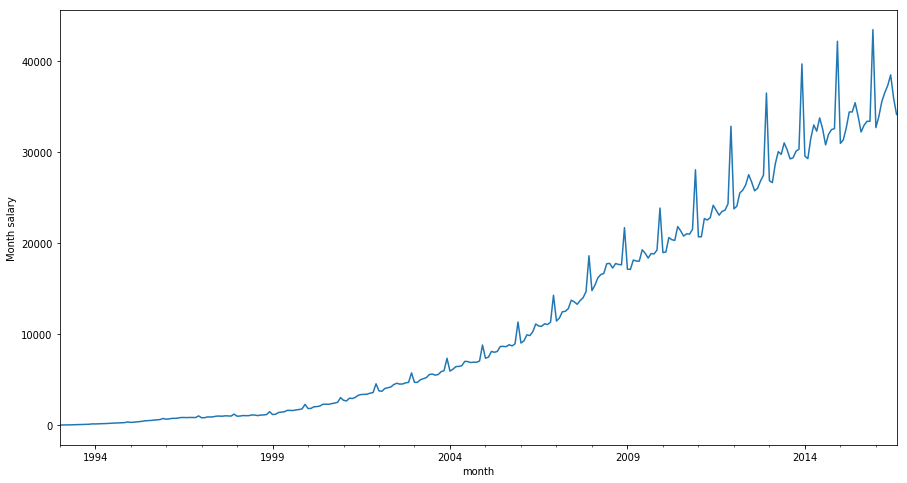

In [59]:
# Первый взгляд на данные
salary.columns = ['money']
plt.figure(figsize = (15,8))
salary.money.plot()
plt.ylabel('Month salary')
plt.show()

Критерий Дики-Фуллера: p=0.991850


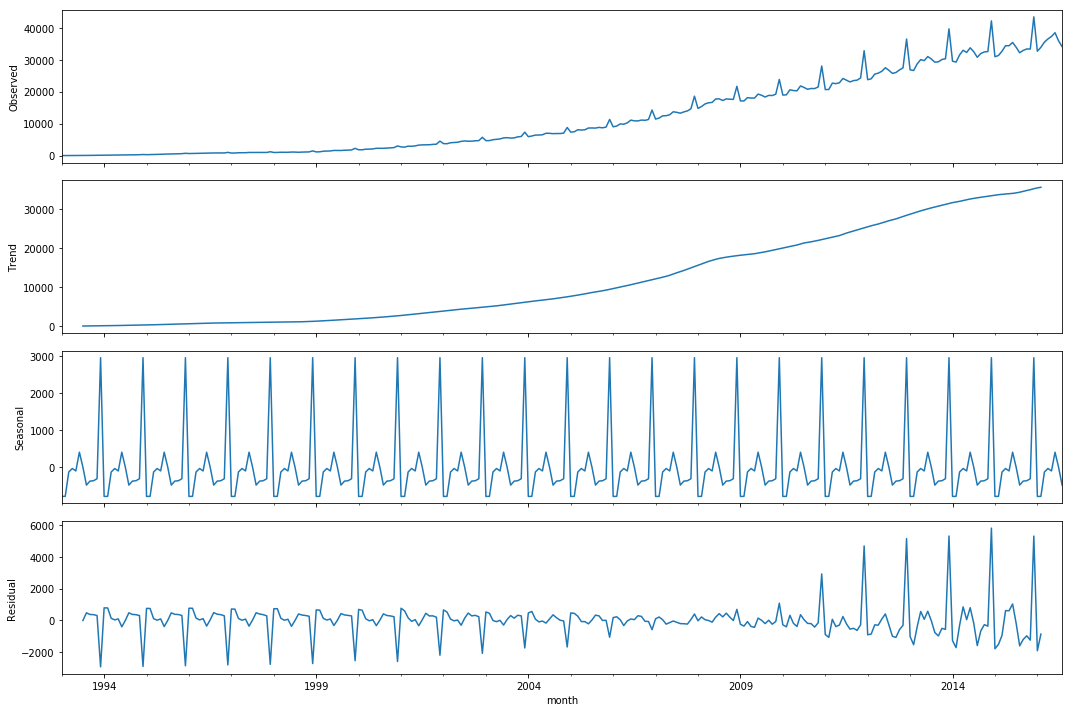

In [18]:
# Произведем STL декомпозицию
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.money).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.money)[1])

Тренд есть, сезонность есть, дисперсия нестабильна
Стабилизация дисперсии методом Box-Cox

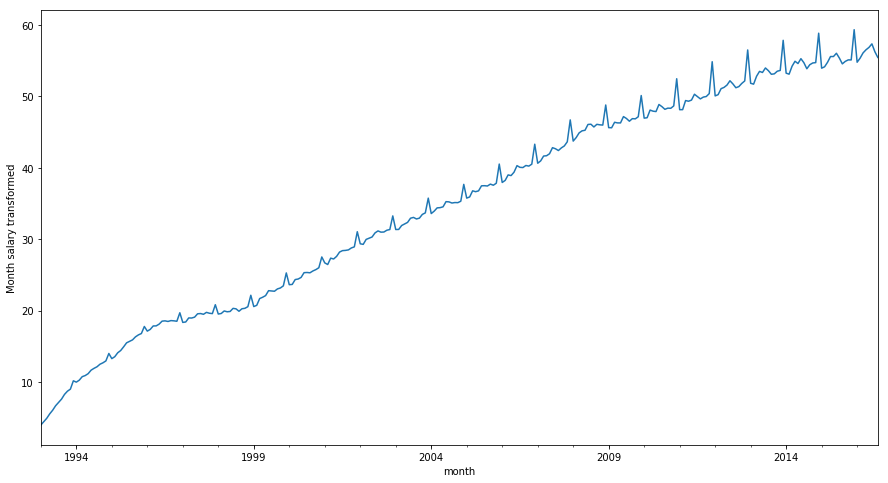

Параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


In [61]:
salary['money_box'], lambda_ = stats.boxcox(salary.money)
plt.figure(figsize = (15,8))
salary.money_box.plot()
plt.ylabel('Month salary transformed')
plt.show()

print("Параметр преобразования Бокса-Кокса: %f" % lambda_)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.money_box)[1])

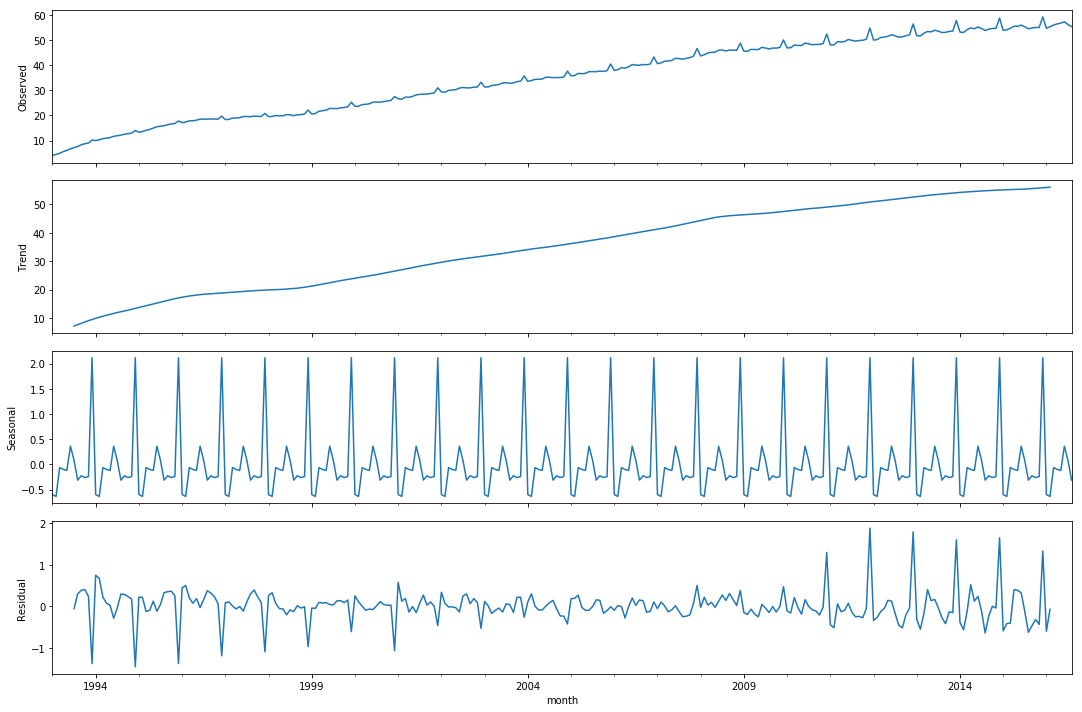

In [62]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.money_box).plot()
plt.show()

Сохраняется и тренд и сезонность
Начнем борьбу с сезонностью сезонным дифференциированием
Затем продифференциируем обычно со смещением 1 для борьбы с трендом.

Критерий Дики-Фуллера: p=0.000000


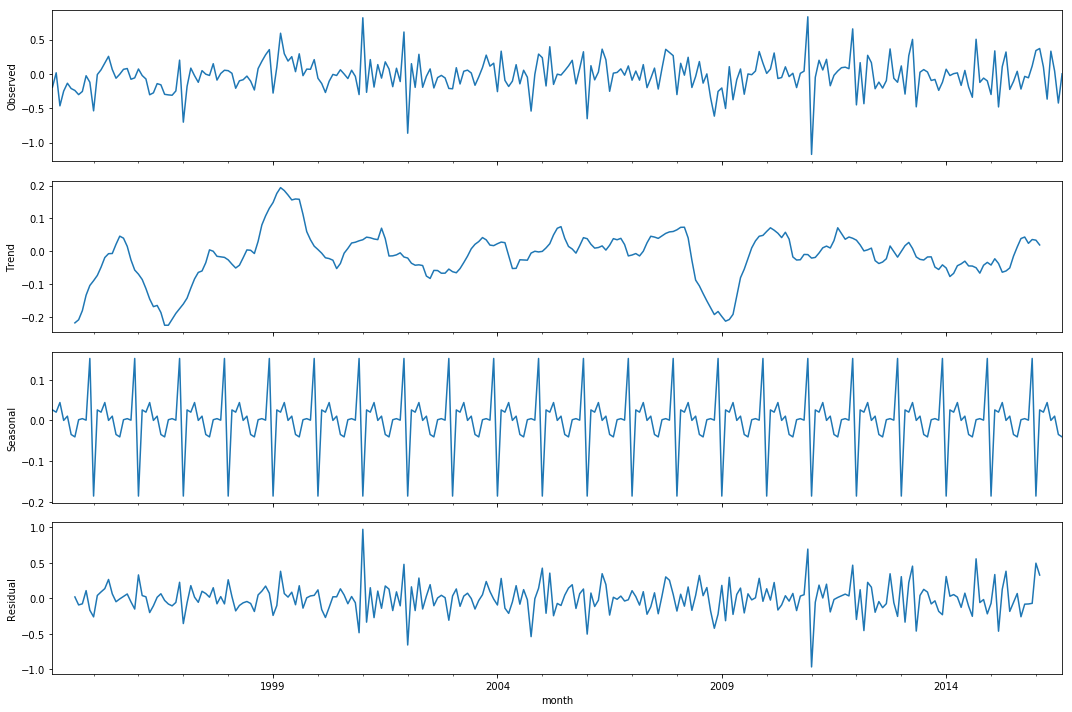

In [63]:
salary['money_box_diff'] = salary.money_box - salary.money_box.shift(12)
salary['money_box_diff2'] = salary.money_box_diff - salary.money_box_diff.shift(1)

sm.tsa.seasonal_decompose(salary.money_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.money_box_diff2[13:])[1])

Гипотеза о нестационарности отвергается, графики визуально выглядят лучше. Нет тренда, остатки похожи на белый шум.
Перейдем к подбору параметров модели SARIMA

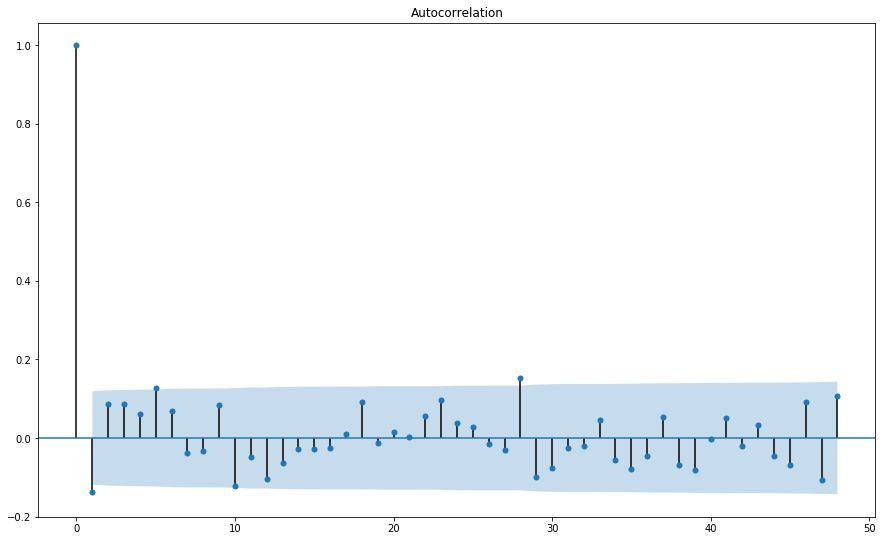

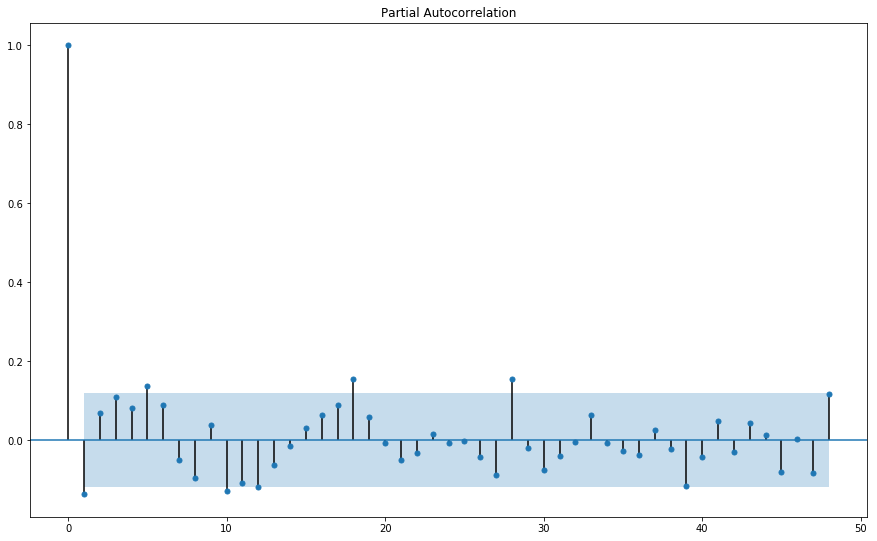

In [64]:
plt.figure(figsize(15,20))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.money_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.money_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [65]:
# Подберем параметры q, Q, p, P исходя из графиков автокореляции и частичной автокреляции
Qs = [0]
qs = range(0, 2)
Ps = [0]
ps = range(0, 11)
d = 1
D = 1

In [66]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

22

Начнем перебор моделей. Всего следует перебрать 22 модели.

In [67]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.money_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
CPU times: user 4.91 s, sys: 78.9 ms, total: 4.99 s
Wall time: 4.78 s


In [68]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
19  (10, 1, 0, 0) -5.958381
13   (7, 1, 0, 0) -3.349420
10   (6, 0, 0, 0) -2.601427
18  (10, 0, 0, 0) -2.325989
8    (5, 0, 0, 0) -2.104961


In [69]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                           money_box   No. Observations:                  284
Model:             SARIMAX(10, 1, 1)x(0, 1, 0, 12)   Log Likelihood                  14.979
Date:                             Tue, 24 Apr 2018   AIC                             -5.958
Time:                                     12:40:22   BIC                             37.829
Sample:                                 01-01-1993   HQIC                            11.597
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4165      0.273      1.526      0.127      -0.118       0.951
ar.L2          0.1512      

Результат скорее всего ожидаемый. Модель содержащая больше всего параметров и будет являться самой оптимальной в данном случае.

Мне данная модель не нравится. В ней слишком много параметров.
Возьмем модель с меньшим кол-вом параметров. 5-я в топе модель.

In [70]:
model=sm.tsa.statespace.SARIMAX(salary.money_box, order=(5, d, 0), 
                                seasonal_order=(0, D, 0, 12)).fit(disp=-1)
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          money_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   7.052
Date:                            Tue, 24 Apr 2018   AIC                             -2.105
Time:                                    12:40:45   BIC                             19.789
Sample:                                01-01-1993   HQIC                             6.673
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1503      0.047     -3.215      0.001      -0.242      -0.059
ar.L2          0.0657      0.070   

Сравним остатки двух моделей, лучшей и выбранной мной

Критерий Стьюдента: p=0.129410
Критерий Дики-Фуллера: p=0.000000


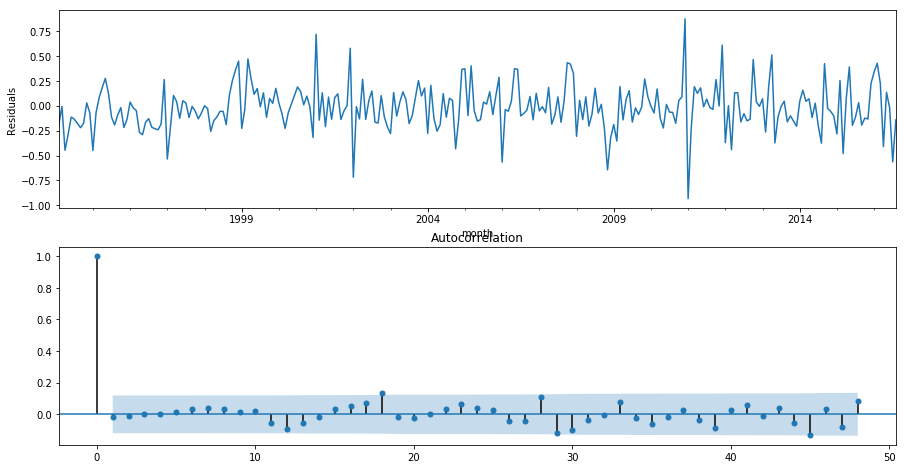

In [71]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.332166
Критерий Дики-Фуллера: p=0.000000


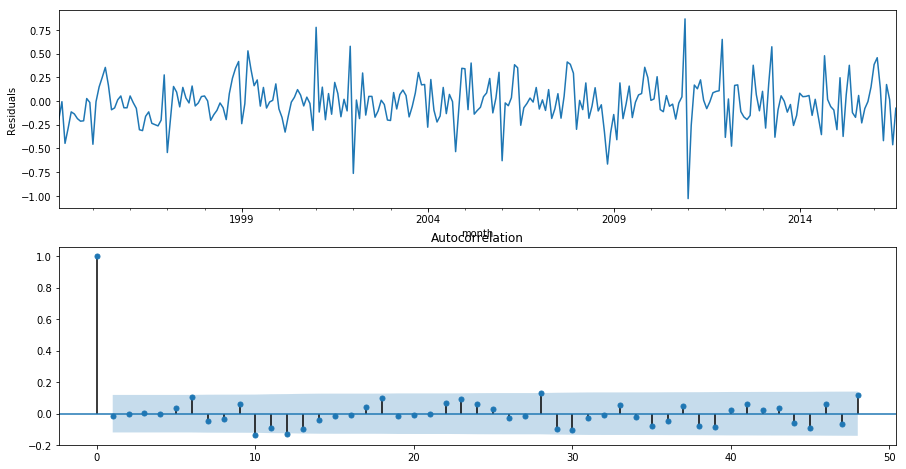

In [72]:
plt.figure(figsize(15,8))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Все остатки стационарны согласно критерию Дики-Фуллера и визуально. Критерий Стьюдента подтверждает их несмещенность.
Сравним насколько хорошо модели описывают имеющиеся данные

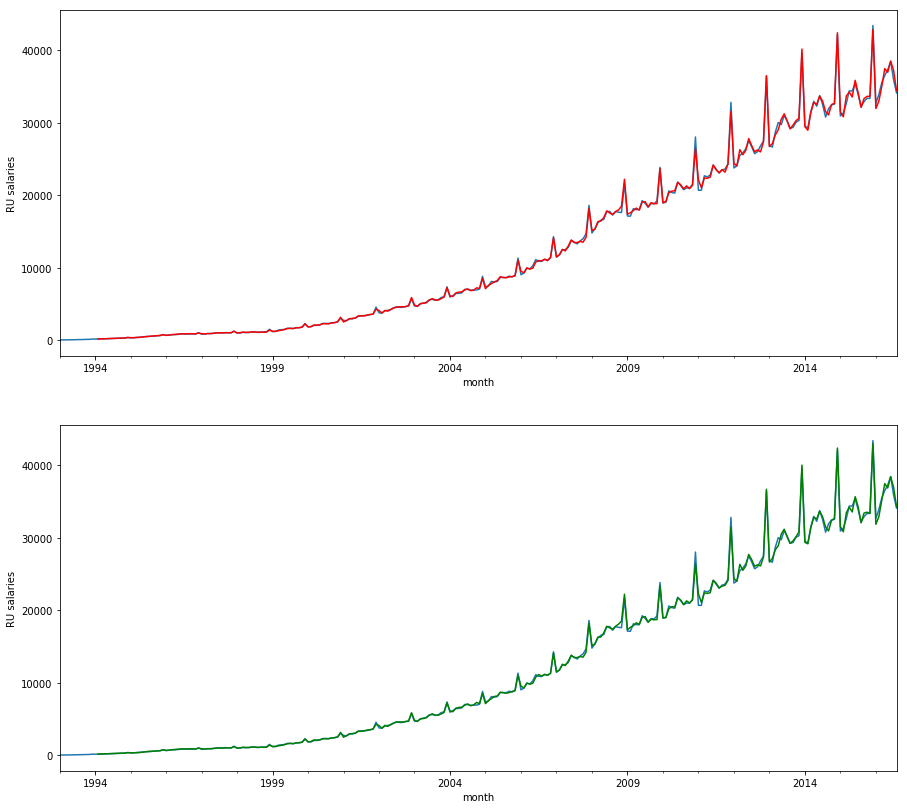

In [73]:
salary['model1'] = invboxcox(best_model.fittedvalues, lambda_)
salary['model2'] = invboxcox(model.fittedvalues, lambda_)
plt.figure(figsize(15,14))
plt.subplot(211)
salary.money.plot()
salary.model1[13:].plot(color='r')
plt.ylabel('RU salaries')
plt.subplot(212)
salary.money.plot()
salary.model2[13:].plot(color='g')
plt.ylabel('RU salaries')
pylab.show()

Обе модели достаточно хорошо описывают данные. Рассмотрим ближе последние 100 наблюдений

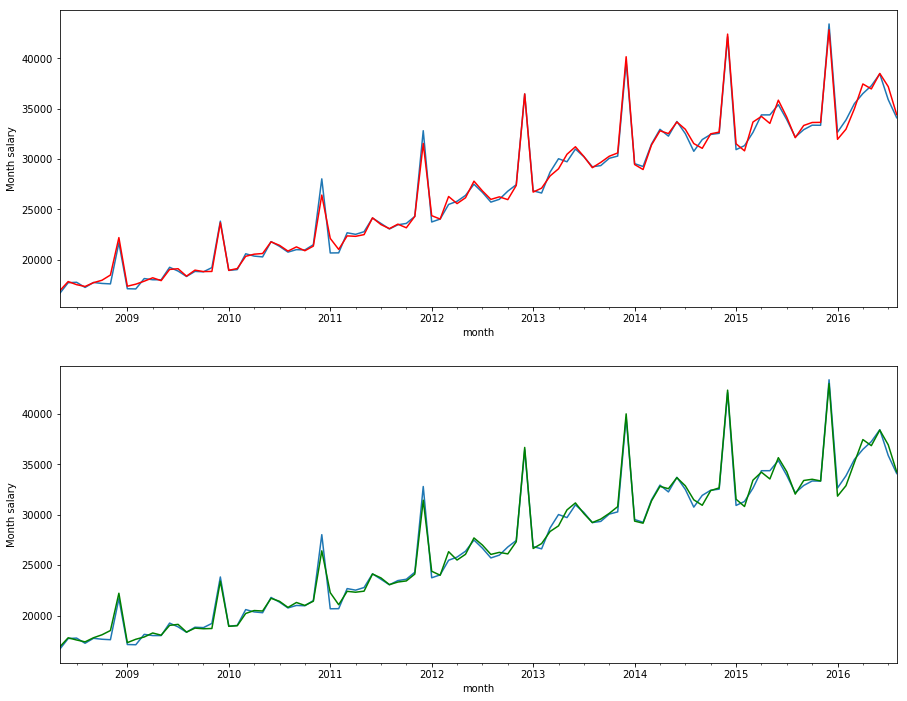

In [82]:
plt.figure(figsize(15,12))
plt.subplot(211)
salary.money[-100:].plot()
salary.model1[-100:].plot(color='r')
plt.ylabel('Month salary')
plt.subplot(212)
salary.money[-100:].plot()
salary.model2[-100:].plot(color='g')
plt.ylabel('Month salary')
pylab.show()

Явных визуальных отличий нет. Как и отличий в остатках. Я выбираю модель SARIMAX(5, 1, 0)x(0, 1, 0, 12) так как в ней меньше коэфициентов 5 против 10 + 1 при незначительном различии в качестве описания данных

Построим предсказания по выбранной модели

In [83]:
salary.index.max()

Timestamp('2016-08-01 00:00:00')

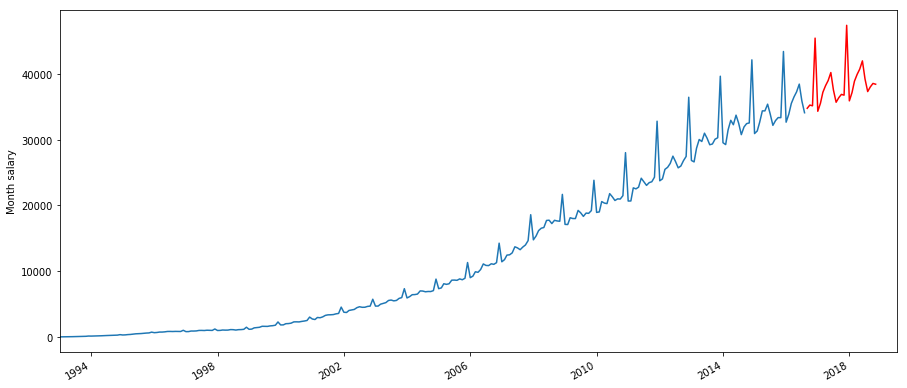

In [84]:
salary_pred = salary[['money']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary_pred.columns)
salary_pred = salary_pred.append(future)

salary_pred['forecast'] = invboxcox(model.predict(start = 284, end = 310), lambda_)

plt.figure(figsize(15,7))
salary_pred.money.plot()
salary_pred.forecast.plot(color='r')
plt.ylabel('Month salary')
pylab.show()

Прогноз по выбранной модели отлично вписывается в существующую модель. Сохраняется тренд, сезонность и дисперсия.

В данной работе я ислледовал имеющийся временной ряд, произвел преобразования Бокса-Кокса и произвел диференциирование для подготовки к построению модели SARIMAX. При помощи графиков ACF, PACF подобрал первоначальные параметры q, Q, p, P для перебора. Произвел перебор моделей и выбрал не лучшую по AIC, а модель с немного большим AIC (в данном случае больше - хуже) но со значительно меньшим кол-вом параметров. Визуально модели описывают данные приблизительно одинаково, обе модели имеют несмещенные остатки, вторая модель (выбранная мною) при этом имеет значительно меньше параметров. Далее я построил прогноз на ближайшие три года (с августа 2016). Прогноз выглядит вполне правдоподобно относительно графика: сохраняется тренд, сезонность и характер дисперсии.